# 📈 Week 8 Trading Strategy: Instance-Based Methods

---

## 🎯 Strategy Overview

**Building on Weeks 1-7 + Adding Week 8 Concepts:**
- Foundation through Factor Models
- Advanced Volatility (GARCH)
- **NEW:** K-Nearest Neighbors (KNN) for regime detection
- **NEW:** Support Vector Regression (SVR) for price prediction
- **NEW:** Distance metrics (Euclidean, Manhattan)
- **NEW:** Historical pattern matching

**Strategy Logic:**
1. Find similar historical market regimes using KNN
2. Use SVR to predict returns based on similar patterns
3. Generate trading signals from pattern-based predictions
4. Combine with volatility-adjusted position sizing

---

In [10]:
# ============================================================
# CONFIGURATION
# ============================================================
TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
BENCHMARK = 'SPY'
LOOKBACK_DAYS = 252 * 3
K_NEIGHBORS = 10
TARGET_VOL = 0.15

print("=" * 60)
print("📊 WEEK 8 TRADING STRATEGY: INSTANCE-BASED METHODS")
print("=" * 60)
print(f"\n🎯 Analyzing: {TICKERS}")
print(f"📅 K-Neighbors: {K_NEIGHBORS}")

📊 WEEK 8 TRADING STRATEGY: INSTANCE-BASED METHODS

🎯 Analyzing: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
📅 K-Neighbors: 10


In [11]:
# ============================================================
# DATA LOADING & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# Fetch data
all_tickers = TICKERS + [BENCHMARK]
end_date = datetime.now()
start_date = end_date - timedelta(days=int(LOOKBACK_DAYS * 1.5))

print("\n📥 Downloading market data...")
data = yf.download(all_tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna().tail(LOOKBACK_DAYS)
volumes = data['Volume'].dropna().tail(LOOKBACK_DAYS)
returns = prices.pct_change().dropna()

print(f"✅ Loaded {len(prices)} trading days")


📥 Downloading market data...
✅ Loaded 756 trading days


---

## 📊 Section 1: Feature Engineering for KNN (Week 8 Concept)

**Market State Features:**
- Returns (1d, 5d, 20d)
- Volatility (realized)
- Moving average ratios
- Volume patterns

**KNN finds similar historical states based on these features!**

In [12]:
# ============================================================
# FEATURE ENGINEERING
# ============================================================

def create_market_state_features(prices, returns, volumes, ticker):
    """Create features representing market state."""
    df = pd.DataFrame(index=returns.index)
    
    # Returns at different horizons
    df['ret_1d'] = returns[ticker]
    df['ret_5d'] = returns[ticker].rolling(5).sum()
    df['ret_20d'] = returns[ticker].rolling(20).sum()
    
    # Volatility
    df['vol_5d'] = returns[ticker].rolling(5).std()
    df['vol_20d'] = returns[ticker].rolling(20).std()
    
    # Price relative to MAs
    close = prices[ticker]
    df['price_ma_10'] = close / close.rolling(10).mean() - 1
    df['price_ma_50'] = close / close.rolling(50).mean() - 1
    
    # RSI
    delta = close.diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    df['rsi'] = 100 - (100 / (1 + gain / loss))
    
    # Volume ratio
    df['vol_ratio'] = volumes[ticker] / volumes[ticker].rolling(20).mean()
    
    # Target: 5-day forward return
    df['target'] = returns[ticker].shift(-5).rolling(5).sum()
    
    return df.dropna()

# Create features for all tickers
feature_dfs = {}
for ticker in TICKERS:
    feature_dfs[ticker] = create_market_state_features(prices, returns, volumes, ticker)
    
print(f"✅ Created {len(feature_dfs[TICKERS[0]].columns)-1} features per ticker")
print(f"Features: {[c for c in feature_dfs[TICKERS[0]].columns if c != 'target']}")

✅ Created 9 features per ticker
Features: ['ret_1d', 'ret_5d', 'ret_20d', 'vol_5d', 'vol_20d', 'price_ma_10', 'price_ma_50', 'rsi', 'vol_ratio']


---

## 📊 Section 2: K-Nearest Neighbors Regime Matching (Week 8 Concept)

**KNN Algorithm:**
1. Define current market state as feature vector
2. Find K most similar historical states
3. Use outcomes of those states to predict current

**Distance Metrics:**
- Euclidean: Standard L2 distance
- Manhattan: Sum of absolute differences

In [13]:
# ============================================================
# KNN REGIME MATCHING
# ============================================================

def knn_regime_analysis(features, k=10):
    """Find similar historical regimes using KNN."""
    
    feature_cols = [c for c in features.columns if c != 'target']
    X = features[feature_cols].values
    y = features['target'].values
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Current state
    current_state = X_scaled[-1:, :]
    
    # Find nearest neighbors in history (exclude last point)
    distances = cdist(current_state, X_scaled[:-1], metric='euclidean')[0]
    nearest_idx = np.argsort(distances)[:k]
    
    # Get outcomes of similar periods
    similar_outcomes = y[:-1][nearest_idx]
    similar_dates = features.index[:-1][nearest_idx]
    similar_distances = distances[nearest_idx]
    
    return {
        'nearest_idx': nearest_idx,
        'similar_dates': similar_dates,
        'similar_outcomes': similar_outcomes,
        'distances': similar_distances,
        'predicted_return': similar_outcomes.mean(),
        'outcome_std': similar_outcomes.std(),
        'scaler': scaler,
        'X_scaled': X_scaled
    }

# Analyze each ticker
print("📊 KNN REGIME ANALYSIS")
print("=" * 80)

knn_results = {}
for ticker in TICKERS:
    result = knn_regime_analysis(feature_dfs[ticker], k=K_NEIGHBORS)
    knn_results[ticker] = result
    
    print(f"\n{ticker}:")
    print(f"   Similar periods: {[d.strftime('%Y-%m-%d') for d in result['similar_dates'][:3]]}")
    print(f"   Predicted 5-day return: {result['predicted_return']:.2%}")
    print(f"   Outcome std: {result['outcome_std']:.2%}")

📊 KNN REGIME ANALYSIS

AAPL:
   Similar periods: ['2026-01-13', '2024-02-28', '2024-01-17']
   Predicted 5-day return: -2.69%
   Outcome std: 4.19%

MSFT:
   Similar periods: ['2023-09-26', '2024-04-18', '2026-01-02']
   Predicted 5-day return: 0.64%
   Outcome std: 2.92%

GOOGL:
   Similar periods: ['2024-01-26', '2024-01-29', '2025-07-30']
   Predicted 5-day return: -2.35%
   Outcome std: 2.90%

AMZN:
   Similar periods: ['2024-01-31', '2025-09-02', '2023-04-11']
   Predicted 5-day return: 0.49%
   Outcome std: 5.40%

META:
   Similar periods: ['2025-10-03', '2026-01-13', '2024-09-06']
   Predicted 5-day return: -0.07%
   Outcome std: 3.31%


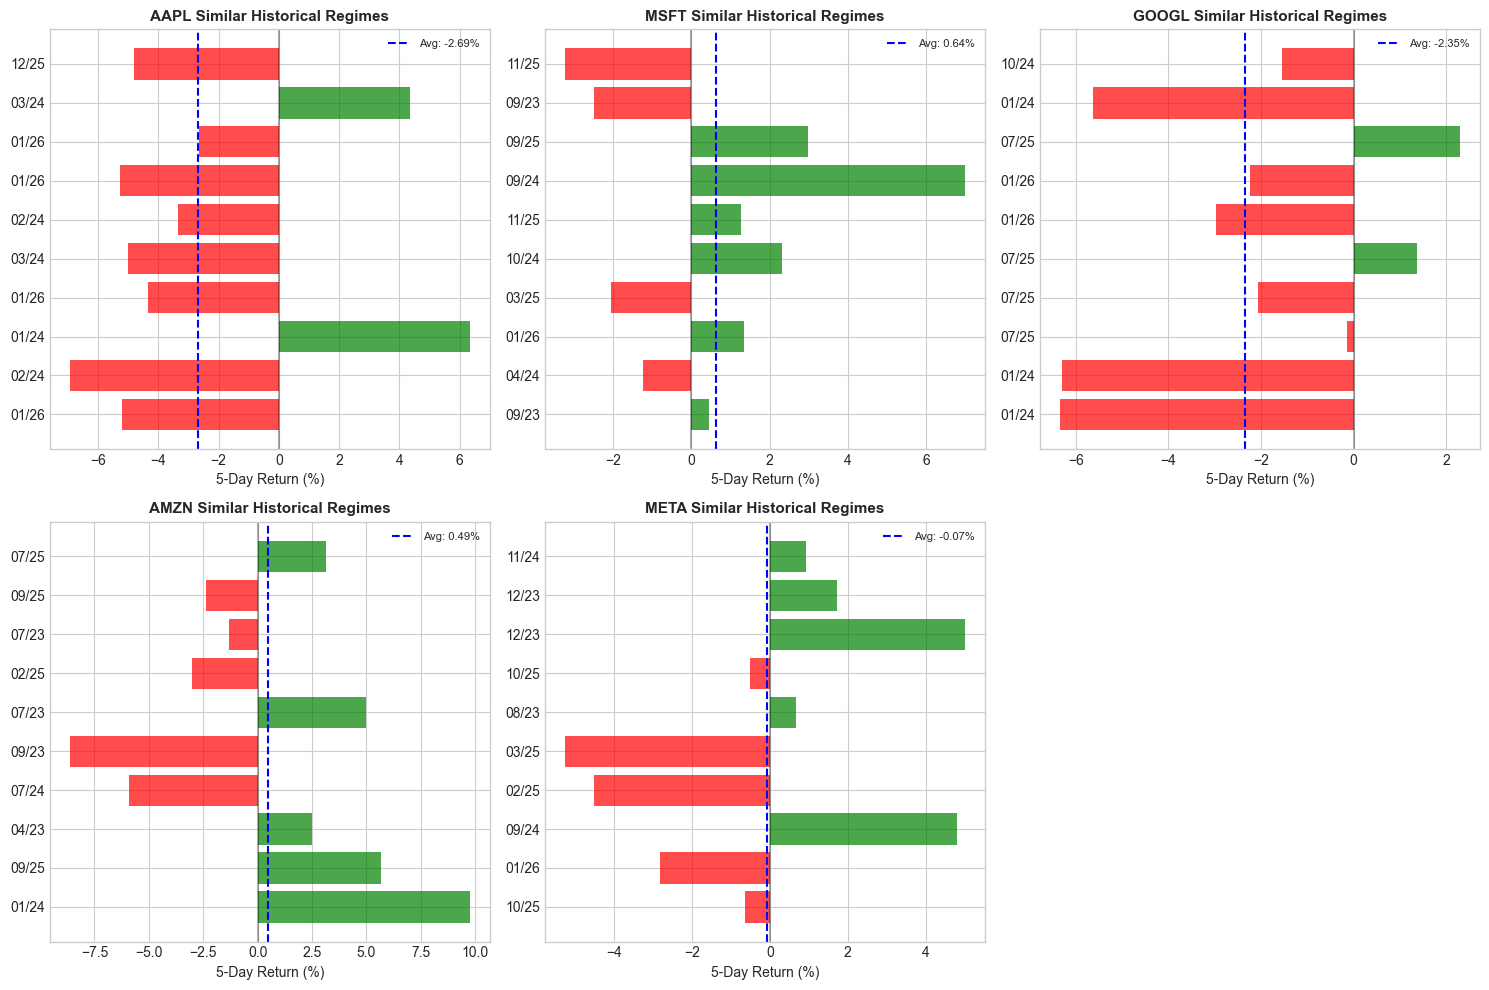

In [14]:
# ============================================================
# VISUALIZATION: Similar Regimes
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, ticker in enumerate(TICKERS):
    ax = axes[i]
    result = knn_results[ticker]
    
    # Bar chart of similar period outcomes
    dates = [d.strftime('%m/%y') for d in result['similar_dates']]
    outcomes = result['similar_outcomes'] * 100
    
    colors = ['green' if o > 0 else 'red' for o in outcomes]
    ax.barh(range(len(dates)), outcomes, color=colors, alpha=0.7)
    ax.set_yticks(range(len(dates)))
    ax.set_yticklabels(dates)
    ax.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    ax.axvline(x=result['predicted_return']*100, color='blue', linestyle='--', 
               label=f"Avg: {result['predicted_return']:.2%}")
    ax.set_xlabel('5-Day Return (%)')
    ax.set_title(f'{ticker} Similar Historical Regimes', fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

---

## 📊 Section 3: Support Vector Regression (Week 8 Concept)

**SVR for Return Prediction:**
- Finds optimal hyperplane in high-dimensional space
- Uses kernel trick for non-linear relationships
- More robust to outliers than linear regression

**ε-insensitive loss:** Ignores errors within tolerance ε

In [15]:
# ============================================================
# SVR PREDICTION MODEL
# ============================================================

def svr_prediction(features, test_size=0.2):
    """Train SVR model for return prediction."""
    
    feature_cols = [c for c in features.columns if c != 'target']
    X = features[feature_cols].values
    y = features['target'].values
    
    # Train/test split
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train SVR with RBF kernel
    svr = SVR(kernel='rbf', C=1.0, epsilon=0.01)
    svr.fit(X_train_scaled, y_train)
    
    # Predictions
    train_pred = svr.predict(X_train_scaled)
    test_pred = svr.predict(X_test_scaled)
    
    # Current prediction
    current_pred = svr.predict(scaler.transform(X[-1:]))[0]
    
    # Metrics
    train_score = svr.score(X_train_scaled, y_train)
    test_score = svr.score(X_test_scaled, y_test)
    
    return {
        'model': svr,
        'scaler': scaler,
        'train_score': train_score,
        'test_score': test_score,
        'train_pred': train_pred,
        'test_pred': test_pred,
        'y_test': y_test,
        'current_prediction': current_pred
    }

# Train SVR for each ticker
print("📊 SVR MODEL RESULTS")
print("=" * 70)

svr_results = {}
print(f"\n{'Ticker':<10} {'Train R²':>12} {'Test R²':>12} {'Predicted Return':>18}")
print("-" * 70)

for ticker in TICKERS:
    result = svr_prediction(feature_dfs[ticker])
    svr_results[ticker] = result
    print(f"{ticker:<10} {result['train_score']:>11.4f} {result['test_score']:>11.4f} {result['current_prediction']:>17.2%}")

📊 SVR MODEL RESULTS

Ticker         Train R²      Test R²   Predicted Return
----------------------------------------------------------------------
AAPL            0.5827     -0.5791            -2.92%
MSFT            0.6999     -0.8453             2.33%
GOOGL           0.6618     -1.0658            -4.53%
AMZN            0.7319     -0.7562            -1.78%
META            0.6146     -1.0991            -0.51%


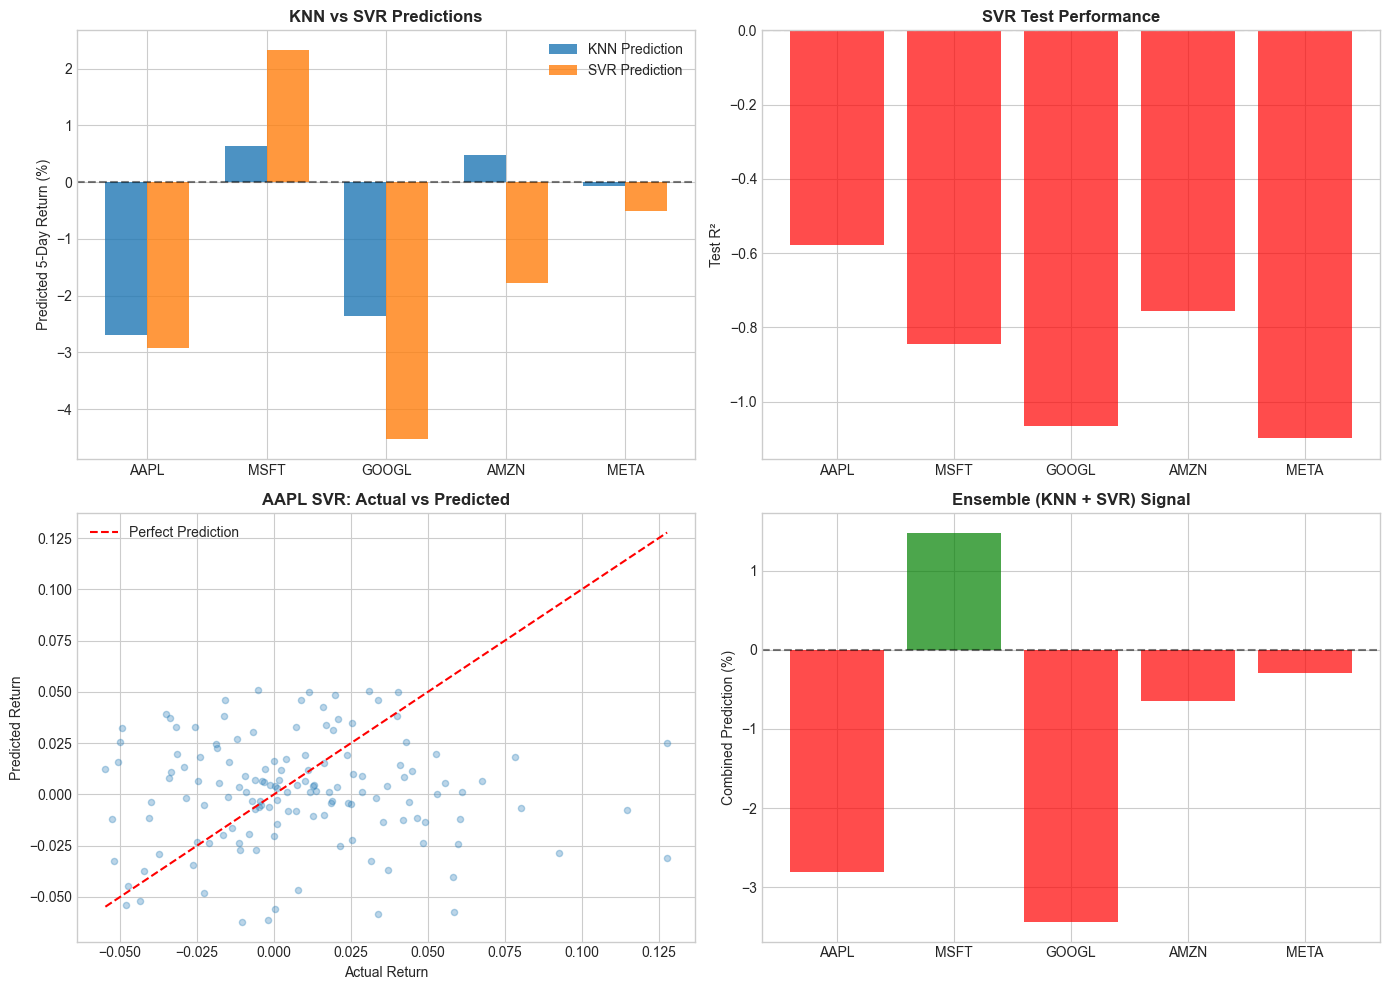

In [16]:
# ============================================================
# MODEL COMPARISON: KNN vs SVR
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Predictions Comparison
ax1 = axes[0, 0]
knn_preds = [knn_results[t]['predicted_return'] for t in TICKERS]
svr_preds = [svr_results[t]['current_prediction'] for t in TICKERS]
x = np.arange(len(TICKERS))
width = 0.35
ax1.bar(x - width/2, np.array(knn_preds)*100, width, label='KNN Prediction', alpha=0.8)
ax1.bar(x + width/2, np.array(svr_preds)*100, width, label='SVR Prediction', alpha=0.8)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax1.set_xticks(x)
ax1.set_xticklabels(TICKERS)
ax1.set_ylabel('Predicted 5-Day Return (%)')
ax1.set_title('KNN vs SVR Predictions', fontsize=12, fontweight='bold')
ax1.legend()

# 2. SVR Test Performance
ax2 = axes[0, 1]
scores = [svr_results[t]['test_score'] for t in TICKERS]
colors = ['green' if s > 0 else 'red' for s in scores]
ax2.bar(TICKERS, scores, color=colors, alpha=0.7)
ax2.set_ylabel('Test R²')
ax2.set_title('SVR Test Performance', fontsize=12, fontweight='bold')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)

# 3. SVR Actual vs Predicted (First ticker)
ax3 = axes[1, 0]
ticker = TICKERS[0]
ax3.scatter(svr_results[ticker]['y_test'], svr_results[ticker]['test_pred'], alpha=0.3, s=20)
ax3.plot([min(svr_results[ticker]['y_test']), max(svr_results[ticker]['y_test'])],
         [min(svr_results[ticker]['y_test']), max(svr_results[ticker]['y_test'])], 
         'r--', label='Perfect Prediction')
ax3.set_xlabel('Actual Return')
ax3.set_ylabel('Predicted Return')
ax3.set_title(f'{ticker} SVR: Actual vs Predicted', fontsize=12, fontweight='bold')
ax3.legend()

# 4. Combined Signal Strength
ax4 = axes[1, 1]
# Average KNN and SVR predictions
combined = [(knn_preds[i] + svr_preds[i])/2 * 100 for i in range(len(TICKERS))]
colors = ['green' if c > 0 else 'red' for c in combined]
ax4.bar(TICKERS, combined, color=colors, alpha=0.7)
ax4.set_ylabel('Combined Prediction (%)')
ax4.set_title('Ensemble (KNN + SVR) Signal', fontsize=12, fontweight='bold')
ax4.axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [17]:
# ============================================================
# TRADING SIGNALS
# ============================================================

print("\n📊 INSTANCE-BASED TRADING SIGNALS")
print("=" * 90)

trading_signals = {}

for ticker in TICKERS:
    knn_pred = knn_results[ticker]['predicted_return']
    svr_pred = svr_results[ticker]['current_prediction']
    knn_conf = 1 / (1 + knn_results[ticker]['outcome_std'])  # Confidence based on outcome consistency
    
    # Ensemble prediction (weighted average)
    ensemble_pred = 0.5 * knn_pred + 0.5 * svr_pred
    
    # Signal generation
    if ensemble_pred > 0.02:
        signal = 'STRONG LONG'
    elif ensemble_pred > 0.005:
        signal = 'LONG'
    elif ensemble_pred < -0.02:
        signal = 'STRONG SHORT'
    elif ensemble_pred < -0.005:
        signal = 'SHORT'
    else:
        signal = 'NEUTRAL'
    
    # Agreement check
    agreement = 'YES' if (knn_pred > 0) == (svr_pred > 0) else 'NO'
    
    trading_signals[ticker] = {
        'knn_pred': knn_pred,
        'svr_pred': svr_pred,
        'ensemble_pred': ensemble_pred,
        'knn_conf': knn_conf,
        'signal': signal,
        'agreement': agreement
    }

print(f"\n{'Ticker':<10} {'KNN Pred':>12} {'SVR Pred':>12} {'Ensemble':>12} {'Signal':>15} {'Agreement':>12}")
print("-" * 90)
for ticker, data in trading_signals.items():
    signal_emoji = "📈📈" if "STRONG LONG" in data['signal'] else ("📈" if "LONG" in data['signal'] else ("📉📉" if "STRONG SHORT" in data['signal'] else ("📉" if "SHORT" in data['signal'] else "⚪")))
    print(f"{ticker:<10} {data['knn_pred']:>11.2%} {data['svr_pred']:>11.2%} {data['ensemble_pred']:>11.2%} {signal_emoji} {data['signal']:<10} {data['agreement']:>10}")


📊 INSTANCE-BASED TRADING SIGNALS

Ticker         KNN Pred     SVR Pred     Ensemble          Signal    Agreement
------------------------------------------------------------------------------------------
AAPL            -2.69%      -2.92%      -2.80% 📉📉 STRONG SHORT        YES
MSFT             0.64%       2.33%       1.48% 📈 LONG              YES
GOOGL           -2.35%      -4.53%      -3.44% 📉📉 STRONG SHORT        YES
AMZN             0.49%      -1.78%      -0.65% 📉 SHORT              NO
META            -0.07%      -0.51%      -0.29% ⚪ NEUTRAL           YES


In [18]:
# ============================================================
# FINAL RECOMMENDATIONS
# ============================================================

print("\n" + "=" * 80)
print("📊 WEEK 8 STRATEGY - FINAL RECOMMENDATIONS")
print("=" * 80)

# Summary
summary = pd.DataFrame({
    'KNN Pred': [trading_signals[t]['knn_pred'] for t in TICKERS],
    'SVR Pred': [trading_signals[t]['svr_pred'] for t in TICKERS],
    'Ensemble': [trading_signals[t]['ensemble_pred'] for t in TICKERS],
    'Signal': [trading_signals[t]['signal'] for t in TICKERS],
    'Agreement': [trading_signals[t]['agreement'] for t in TICKERS]
}, index=TICKERS)

print("\n📋 INSTANCE-BASED ANALYSIS SUMMARY:")
print(summary.round(4).to_string())

# Best opportunities
best_long = summary['Ensemble'].idxmax()
best_short = summary['Ensemble'].idxmin()

print("\n🏆 KEY RECOMMENDATIONS:")
print(f"\n1. 📈 STRONGEST LONG: {best_long}")
print(f"   Ensemble Prediction: {summary.loc[best_long, 'Ensemble']:.2%}")
print(f"   Similar historical periods were profitable!")

print(f"\n2. 📉 STRONGEST SHORT: {best_short}")
print(f"   Ensemble Prediction: {summary.loc[best_short, 'Ensemble']:.2%}")

# High confidence (agreement)
high_conf = [t for t in TICKERS if trading_signals[t]['agreement'] == 'YES']
print(f"\n3. ✅ HIGH CONFIDENCE (KNN & SVR agree): {high_conf}")

# Signals summary
strong_longs = [t for t in TICKERS if 'STRONG LONG' in trading_signals[t]['signal']]
longs = [t for t in TICKERS if trading_signals[t]['signal'] == 'LONG']
shorts = [t for t in TICKERS if 'SHORT' in trading_signals[t]['signal']]

print(f"\n📈 STRONG LONG: {strong_longs if strong_longs else 'None'}")
print(f"📈 LONG: {longs if longs else 'None'}")
print(f"📉 SHORT: {shorts if shorts else 'None'}")

print("\n" + "=" * 80)
print("⚠️ DISCLAIMER: Educational purposes only. Not financial advice!")
print("=" * 80)


📊 WEEK 8 STRATEGY - FINAL RECOMMENDATIONS

📋 INSTANCE-BASED ANALYSIS SUMMARY:
       KNN Pred  SVR Pred  Ensemble        Signal Agreement
AAPL    -0.0269   -0.0292   -0.0280  STRONG SHORT       YES
MSFT     0.0064    0.0233    0.0148          LONG       YES
GOOGL   -0.0235   -0.0453   -0.0344  STRONG SHORT       YES
AMZN     0.0049   -0.0178   -0.0065         SHORT        NO
META    -0.0007   -0.0051   -0.0029       NEUTRAL       YES

🏆 KEY RECOMMENDATIONS:

1. 📈 STRONGEST LONG: MSFT
   Ensemble Prediction: 1.48%
   Similar historical periods were profitable!

2. 📉 STRONGEST SHORT: GOOGL
   Ensemble Prediction: -3.44%

3. ✅ HIGH CONFIDENCE (KNN & SVR agree): ['AAPL', 'MSFT', 'GOOGL', 'META']

📈 STRONG LONG: None
📈 LONG: ['MSFT']
📉 SHORT: ['AAPL', 'GOOGL', 'AMZN']

⚠️ DISCLAIMER: Educational purposes only. Not financial advice!


---

## 📚 Key Concepts Used (Week 1-8)

| Week | Concept | Application |
|------|---------|-------------|
| 1-7 | Prior Concepts | Feature engineering |
| **8** | **K-Nearest Neighbors** | **Regime matching** |
| **8** | **Support Vector Regression** | **Return prediction** |
| **8** | **Distance Metrics** | **Similarity calculation** |
| **8** | **Ensemble Methods** | **Combining KNN + SVR** |

---